<a href="https://colab.research.google.com/github/jeonghojo00/MachineLearning/blob/main/House_Prices_Advanced_Regression_Techniques.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#0. Initial Setup

In [2]:
# Mount google drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
mount='/content/drive'
drive_root = mount + "/MyDrive/Colab Notebooks/DB/Regression"
%cd $drive_root

/content/drive/MyDrive/Colab Notebooks/DB/Regression


In [4]:
!pip install xgboost

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [50]:
# Utility
import os
import glob
from statistics import mean

# Data
import pandas as pd
import numpy as np

# Data visualize
import matplotlib.pyplot as plt
import seaborn as sns

# Model
from sklearn.preprocessing import LabelEncoder, StandardScaler, MinMaxScaler, MaxAbsScaler
from sklearn.model_selection import train_test_split, cross_val_score, RepeatedStratifiedKFold
from sklearn import metrics
from sklearn.metrics import mean_absolute_error,mean_squared_error, r2_score
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.svm import SVR
from xgboost.sklearn import XGBRegressor
import torch

In [8]:
txtfiles = []
for file in glob.glob("./house-prices-advanced-regression-techniques/*"):
    txtfiles.append(file)
for i, filename in enumerate(txtfiles):
    print(f"index: {i}, filename: {filename}")

index: 0, filename: ./house-prices-advanced-regression-techniques/train.csv
index: 1, filename: ./house-prices-advanced-regression-techniques/data_description.txt
index: 2, filename: ./house-prices-advanced-regression-techniques/sample_submission.csv
index: 3, filename: ./house-prices-advanced-regression-techniques/test.csv


In [9]:
sample = txtfiles[2]
sample_df = pd.read_csv(sample)
sample_df.head()

,Id,SalePrice
0,1461,169277.052498
1,1462,187758.393989
2,1463,183583.683570
3,1464,179317.477511
4,1465,150730.079977


In [10]:
train = txtfiles[0]
train_df = pd.read_csv(train)
train_df.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [11]:
test = txtfiles[3]
test_df = pd.read_csv(test)
test_df.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,1461,20,RH,80.0,11622,Pave,NaN,Reg,Lvl,AllPub,...,120,0,NaN,MnPrv,NaN,0,6,2010,WD,Normal
1,1462,20,RL,81.0,14267,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,NaN,Gar2,12500,6,2010,WD,Normal
2,1463,60,RL,74.0,13830,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,MnPrv,NaN,0,3,2010,WD,Normal
3,1464,60,RL,78.0,9978,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,NaN,NaN,0,6,2010,WD,Normal
4,1465,120,RL,43.0,5005,Pave,NaN,IR1,HLS,AllPub,...,144,0,NaN,NaN,NaN,0,1,2010,WD,Normal


#1. Feature Engineering

## 1_1. Handling missing values

In [12]:
missing_values_cols = train_df.columns[train_df.isnull().any()]
print(f"{len(missing_values_cols)} columns have missing values for all {len(train_df.columns)} columns")

19 columns have missing values for all 81 columns


In [13]:
missing_val_count_by_column = (train_df.isnull().sum())
missings = missing_val_count_by_column[missing_val_count_by_column > 0].sort_values(ascending=False)
missings_counts = pd.DataFrame(missings, columns=['missings'])
missings_counts['missings_percent'] = missings_counts['missings']/len(train_df)*100
missings_counts

,missings,missings_percent
PoolQC,1453,99.520548
MiscFeature,1406,96.301370
Alley,1369,93.767123
Fence,1179,80.753425
FireplaceQu,690,47.260274
LotFrontage,259,17.739726
GarageType,81,5.547945
GarageYrBlt,81,5.547945
GarageFinish,81,5.547945
GarageQual,81,5.547945


In [14]:
num_missings = train_df.isna().sum().sum()
print(f"Total {num_missings} missing values")
print(f"Missing values consist of {num_missings / train_df.count().sum() *100:.2} percent of all data points")

Total 6965 missing values
Missing values consist of 6.3 percent of all data points


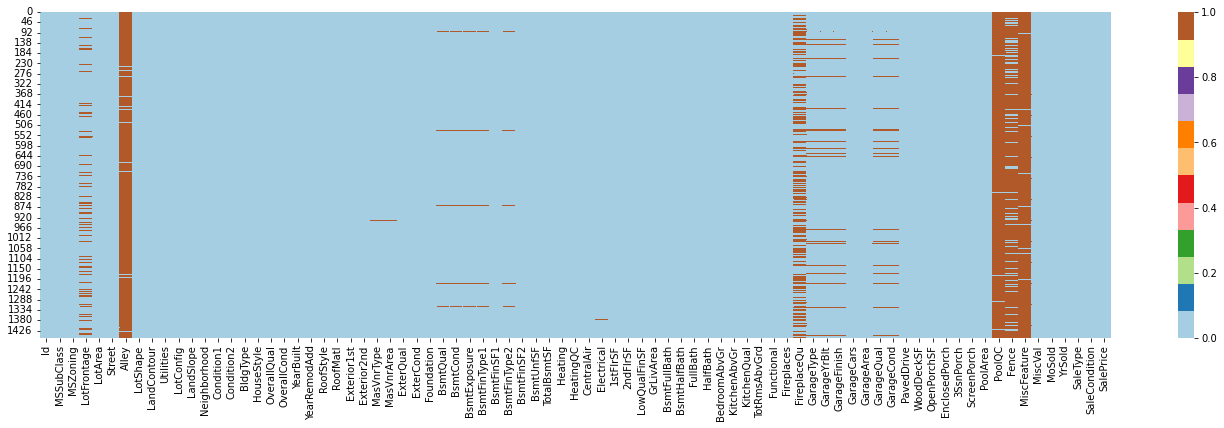

In [15]:
# Visualize missing values
plt.figure(figsize=(24, 6))
sns.heatmap(train_df.isna(), cmap='Paired')

### 1_1_1. Delete columns with % missings

In [ ]:
threshold = 0.0000000001
#Dropping columns with missing value rate higher than threshold
new_train_df = train_df[train_df.columns[train_df.isnull().mean() < threshold]]

In [ ]:
missing_values_cols = new_train_df.columns[new_train_df.isnull().any()]
print(f"{len(missing_values_cols)} columns have missing values for all {len(new_train_df.columns)} columns")

missing_val_count_by_column = (new_train_df.isnull().sum())
missings = missing_val_count_by_column[missing_val_count_by_column > 0].sort_values(ascending=False)
missings_counts = pd.DataFrame(missings, columns=['missings'])
missings_counts['missings_percent'] = missings_counts['missings']/len(new_train_df)*100
missings_counts

0 columns have missing values for all 62 columns


,missings,missings_percent


In [ ]:
new_train_df

,Id,MSSubClass,MSZoning,LotArea,Street,LotShape,LandContour,Utilities,LotConfig,LandSlope,...,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,8450,Pave,Reg,Lvl,AllPub,Inside,Gtl,...,0,0,0,0,0,2,2008,WD,Normal,208500
1,2,20,RL,9600,Pave,Reg,Lvl,AllPub,FR2,Gtl,...,0,0,0,0,0,5,2007,WD,Normal,181500
2,3,60,RL,11250,Pave,IR1,Lvl,AllPub,Inside,Gtl,...,0,0,0,0,0,9,2008,WD,Normal,223500
3,4,70,RL,9550,Pave,IR1,Lvl,AllPub,Corner,Gtl,...,272,0,0,0,0,2,2006,WD,Abnorml,140000
4,5,60,RL,14260,Pave,IR1,Lvl,AllPub,FR2,Gtl,...,0,0,0,0,0,12,2008,WD,Normal,250000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1455,1456,60,RL,7917,Pave,Reg,Lvl,AllPub,Inside,Gtl,...,0,0,0,0,0,8,2007,WD,Normal,175000
1456,1457,20,RL,13175,Pave,Reg,Lvl,AllPub,Inside,Gtl,...,0,0,0,0,0,2,2010,WD,Normal,210000
1457,1458,70,RL,9042,Pave,Reg,Lvl,AllPub,Inside,Gtl,...,0,0,0,0,2500,5,2010,WD,Normal,266500
1458,1459,20,RL,9717,Pave,Reg,Lvl,AllPub,Inside,Gtl,...,112,0,0,0,0,4,2010,WD,Normal,142125


### 1_1_2. Delete all columns with missing values

In [ ]:
# Drop all the columns with missing values
cols_with_missing = [col for col in train_df.columns if train_df[col].isnull().any()]

In [ ]:
train_df_without_missing = train_df.drop(cols_with_missing, axis=1)
test_df_without_missing = test_df.drop(cols_with_missing, axis=1)
print("Train df without missing values")
display(train_df_without_missing.head())
print("Test df without missing values")
display(test_df_without_missing.head())

Train df without missing values


,Id,MSSubClass,MSZoning,LotArea,Street,LotShape,LandContour,Utilities,LotConfig,LandSlope,...,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,8450,Pave,Reg,Lvl,AllPub,Inside,Gtl,...,0,0,0,0,0,2,2008,WD,Normal,208500
1,2,20,RL,9600,Pave,Reg,Lvl,AllPub,FR2,Gtl,...,0,0,0,0,0,5,2007,WD,Normal,181500
2,3,60,RL,11250,Pave,IR1,Lvl,AllPub,Inside,Gtl,...,0,0,0,0,0,9,2008,WD,Normal,223500
3,4,70,RL,9550,Pave,IR1,Lvl,AllPub,Corner,Gtl,...,272,0,0,0,0,2,2006,WD,Abnorml,140000
4,5,60,RL,14260,Pave,IR1,Lvl,AllPub,FR2,Gtl,...,0,0,0,0,0,12,2008,WD,Normal,250000


Test df without missing values


,Id,MSSubClass,MSZoning,LotArea,Street,LotShape,LandContour,Utilities,LotConfig,LandSlope,...,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,1461,20,RH,11622,Pave,Reg,Lvl,AllPub,Inside,Gtl,...,0,0,0,120,0,0,6,2010,WD,Normal
1,1462,20,RL,14267,Pave,IR1,Lvl,AllPub,Corner,Gtl,...,36,0,0,0,0,12500,6,2010,WD,Normal
2,1463,60,RL,13830,Pave,IR1,Lvl,AllPub,Inside,Gtl,...,34,0,0,0,0,0,3,2010,WD,Normal
3,1464,60,RL,9978,Pave,IR1,Lvl,AllPub,Inside,Gtl,...,36,0,0,0,0,0,6,2010,WD,Normal
4,1465,120,RL,5005,Pave,IR1,HLS,AllPub,Inside,Gtl,...,82,0,0,144,0,0,1,2010,WD,Normal


### 1_1_3. Imputation

In [16]:
missing_values_cols

Index(['LotFrontage', 'Alley', 'MasVnrType', 'MasVnrArea', 'BsmtQual',
       'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2',
       'Electrical', 'FireplaceQu', 'GarageType', 'GarageYrBlt',
       'GarageFinish', 'GarageQual', 'GarageCond', 'PoolQC', 'Fence',
       'MiscFeature'],
      dtype='object')

In [17]:
# Categorize by data type
col_types = dict()
for col in missing_values_cols:
    if train_df[col].dtypes in col_types:
        col_types[train_df[col].dtypes].append(col)
    else:
        col_types[train_df[col].dtypes] = list()
        col_types[train_df[col].dtypes].append(col)
display(col_types)
col_types_keys = list(col_types.keys())
print(col_types_keys)

{dtype('float64'): ['LotFrontage', 'MasVnrArea', 'GarageYrBlt'],
 dtype('O'): ['Alley',
  'MasVnrType',
  'BsmtQual',
  'BsmtCond',
  'BsmtExposure',
  'BsmtFinType1',
  'BsmtFinType2',
  'Electrical',
  'FireplaceQu',
  'GarageType',
  'GarageFinish',
  'GarageQual',
  'GarageCond',
  'PoolQC',
  'Fence',
  'MiscFeature']}

[dtype('float64'), dtype('O')]


#### 1_1_3_1. Float64

##### LotFrontage Column

Column Name :  LotFrontage
Data Type   :  float64


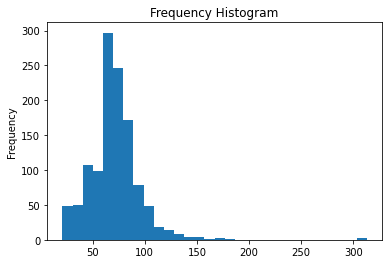

In [18]:
# LotFrontage Column
idx = 0
col_name = col_types[col_types_keys[0]][idx]
print("Column Name : ", col_name)
print("Data Type   : ", train_df[col_name].dtypes)
# Plot Histogram on x
plt.hist(train_df[col_name], bins=30)
plt.gca().set(title='Frequency Histogram', ylabel='Frequency');

In [19]:
# Impute "LotFrontage" column with its mean value (due to normal distribution)
train_df['LotFrontage'] = train_df['LotFrontage'].fillna(train_df['LotFrontage'].mean())

##### MasVnrArea Column

Column Name :  MasVnrArea
Data Type   :  float64


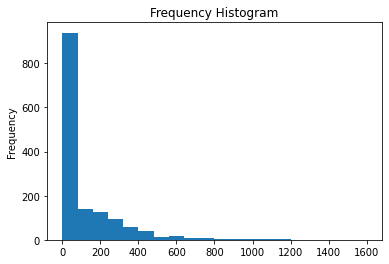

In [20]:
# MasVnrArea Column
idx = 1
col_name = col_types[col_types_keys[0]][idx]
print("Column Name : ", col_name)
print("Data Type   : ", train_df[col_name].dtypes)
# Plot Histogram on x
plt.hist(train_df[col_name], bins=20)
plt.gca().set(title='Frequency Histogram', ylabel='Frequency');

In [21]:
# Impute "MasVnrArea" column with median (positively skewed distribution)
train_df['MasVnrArea'] = train_df['MasVnrArea'].fillna(train_df['MasVnrArea'].median())

##### GarageYrBlt Column

Column Name :  GarageYrBlt
Data Type   :  float64


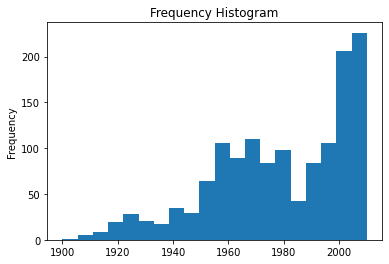

In [22]:
# GarageYrBlt Column
idx = 2
col_name = col_types[col_types_keys[0]][idx]
print("Column Name : ", col_name)
print("Data Type   : ", train_df[col_name].dtypes)
# Plot Histogram on x
plt.hist(train_df[col_name], bins=20)
plt.gca().set(title='Frequency Histogram', ylabel='Frequency');

In [23]:
# Impute "GarageYrBlt" column with median (negatively skewed distribution)
train_df['GarageYrBlt']= train_df['GarageYrBlt'].fillna(train_df['GarageYrBlt'].median())

#### 1_1_3_2. Object dtypes

In [24]:
col_types[col_types_keys[1]]

['Alley',
 'MasVnrType',
 'BsmtQual',
 'BsmtCond',
 'BsmtExposure',
 'BsmtFinType1',
 'BsmtFinType2',
 'Electrical',
 'FireplaceQu',
 'GarageType',
 'GarageFinish',
 'GarageQual',
 'GarageCond',
 'PoolQC',
 'Fence',
 'MiscFeature']

In [25]:
# Fill all missing values with the most frequent values
for col in col_types[col_types_keys[1]]:
    train_df[col] = train_df[col].fillna(train_df[col].mode()[0])

### 1_1_4. Check missing values again

In [26]:
# Check all missing values are handled
train_df.isna().sum().sort_values(ascending=False).head(10)

Id              0
CentralAir      0
GarageYrBlt     0
GarageType      0
FireplaceQu     0
Fireplaces      0
Functional      0
TotRmsAbvGrd    0
KitchenQual     0
KitchenAbvGr    0
dtype: int64

### 1_1_5. Run for Test_df

In [ ]:
missing_values_cols= test_df.columns[test_df.isnull().any()]
print(f"{len(missing_values_cols)} columns have missing values for all {len(test_df.columns)} columns")

missing_val_count_by_column = (test_df.isnull().sum())
missings = missing_val_count_by_column[missing_val_count_by_column > 0].sort_values(ascending=False)
missings_counts = pd.DataFrame(missings, columns=['missings'])
missings_counts['missings_percent'] = missings_counts['missings']/len(test_df)*100
missings_counts

## 1_2. Data Analysis

In [27]:
# Defining how required variables correlate to our target variable
corr = train_df.corr()
corr.sort_values(['SalePrice'], ascending=False, inplace=True)
corr.SalePrice.head(10)

SalePrice       1.000000
OverallQual     0.790982
GrLivArea       0.708624
GarageCars      0.640409
GarageArea      0.623431
TotalBsmtSF     0.613581
1stFlrSF        0.605852
FullBath        0.560664
TotRmsAbvGrd    0.533723
YearBuilt       0.522897
Name: SalePrice, dtype: float64

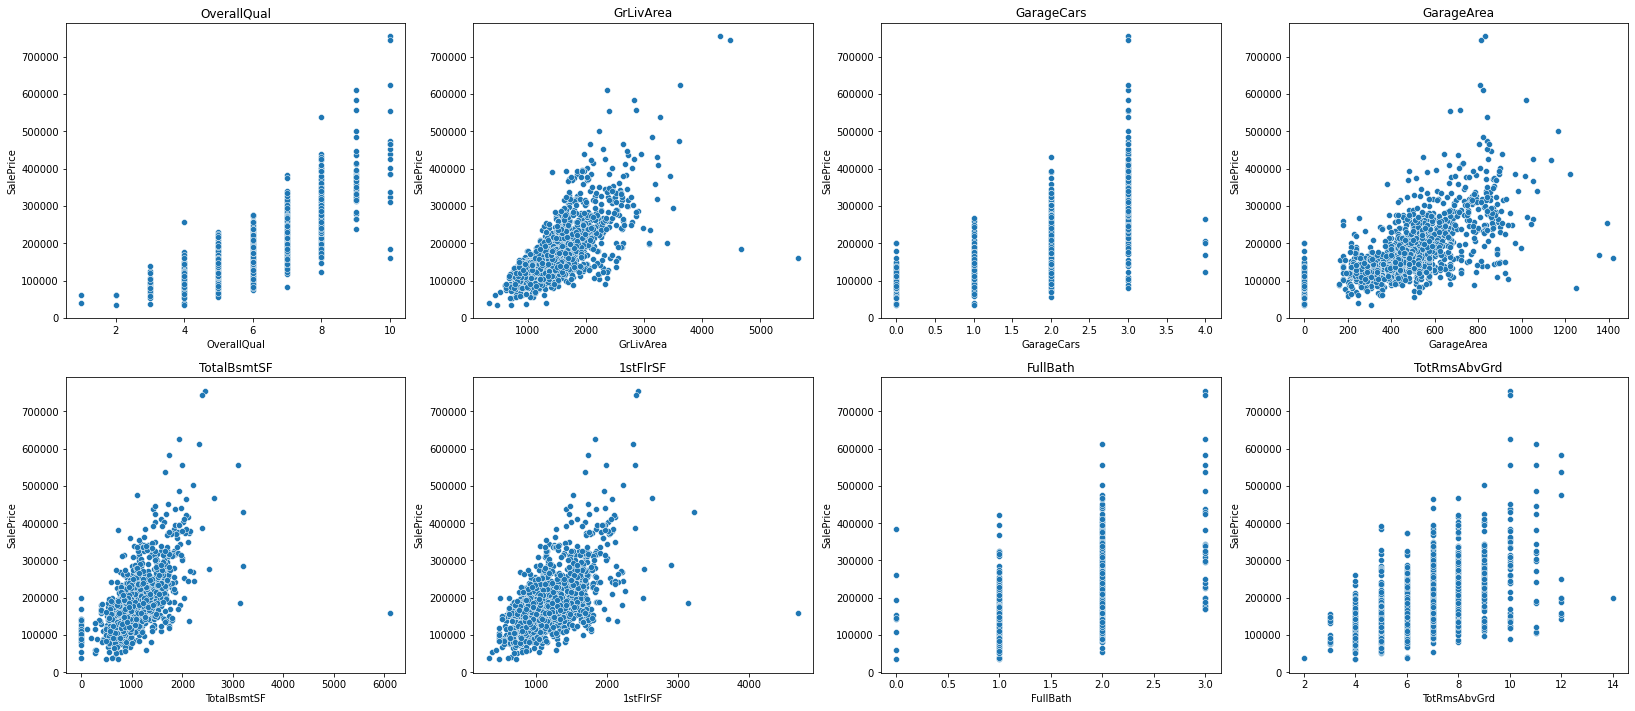

In [28]:
plt.figure(figsize=(28, 25))
plt.rcParams['font.size'] = '10'
num_to_display = 8
corr.SalePrice.index[1:11]
for i in range(1, num_to_display+1):
    plt.subplot(4, 4, i)
    col = corr.SalePrice.index[i]
    plt.title(col)
    sns.scatterplot(x=col, y='SalePrice', data=train_df)

##1_3. Convert Non-numerical values into Numerical

In [29]:
label_enc = LabelEncoder()
for col in train_df.columns:
    if train_df[col].dtypes == object:
        train_df[col] = label_enc.fit_transform(train_df[col])

In [30]:
set(train_df.dtypes)

{dtype('int64'), dtype('float64')}

#2. Data Preparation

In [31]:
X = train_df.drop(['Id', "SalePrice"], axis=1)
y = train_df['SalePrice']

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

#3. Model Selection

In [32]:
'''
Scoring: 
    1. Mean Absolute Error (MAE)
    2. Mean Squared Error (MSE)
    3. Root Mean Squared Error (RMSE)
    4. R-Squared (R2)

Regression models:
    1. LinearRegression
    2. DecisionTreeRegressor
    3. RandomForestRegressor
    4. KNeighborsRegressor
    5. GradientBoostingRegressor
    6. SVR (Support Vector Machine Regressor)
    7. XGBRegressor
'''

'\nScoring: \n    1. Mean Absolute Error (MAE)\n    2. Mean Squared Error (MSE)\n    3. Root Mean Squared Error (RMSE)\n    4. R-Squared (R2)\n\nRegression models:\n    1. LinearRegression\n    2. DecisionTreeRegressor\n    3. RandomForestRegressor\n    4. KNeighborsRegressor\n    5. GradientBoostingRegressor\n    6. SVR (Support Vector Machine Regressor)\n    7. XGBRegressor\n'

In [33]:
def evaluate_model(model, X, y, n_splits = 10):
    mae = cross_val_score(model, X, y, cv = n_splits, scoring='neg_mean_absolute_error')
    mse = cross_val_score(model, X, y, cv = n_splits, scoring='neg_mean_squared_error')
    rmse = cross_val_score(model, X, y, cv = n_splits, scoring='neg_root_mean_squared_error')
    msle = cross_val_score(model, X, y, cv = n_splits, scoring='neg_mean_squared_log_error')
    r2 = cross_val_score(model, X, y, cv = n_splits, scoring='r2')

    results = dict()
    results['MAE'] = abs(mean(mae))
    results['MSE'] = abs(mean(mse))
    results['RMSE'] = abs(mean(rmse))
    results['MSLE'] = abs(mean(msle))
    results['R2'] = mean(r2)
    return results

In [34]:
results = dict()

In [35]:
# Linear Regressor
model = LinearRegression()
results['LinearRegression'] = evaluate_model(model, X, y, n_splits=10)
results['LinearRegression']

/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:774: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_scorer.py", line 103, in __call__
    score = scorer._score(cached_call, estimator, *args, **kwargs)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_scorer.py", line 264, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_regression.py", line 522, in mean_squared_log_error
    "Mean Squared Logarithmic Error cannot be used when "
ValueError: Mean Squared Logarithmic Error cannot be used when targets contain negative values.

  U

{'MAE': 20240.297827897986,
 'MSE': 1343191715.6307428,
 'RMSE': 34637.0925663753,
 'MSLE': nan,
 'R2': 0.7978402321980244}

In [36]:
# Decision Tree Regressor
model = DecisionTreeRegressor(random_state = 42)
results['DecisionTreeRegressor'] = evaluate_model(model, X, y, n_splits=10)
results['DecisionTreeRegressor']

{'MAE': 25992.146575342464,
 'MSE': 1620293886.4780822,
 'RMSE': 39594.82895167942,
 'MSLE': 0.042319287977494735,
 'R2': 0.7395344472067813}

In [37]:
# Random Forest Regressor
model = RandomForestRegressor(random_state = 42)
results['RandomForestRegressor'] = evaluate_model(model, X, y, n_splits=10)
results['RandomForestRegressor']

{'MAE': 17336.135630136985,
 'MSE': 873377933.0433462,
 'RMSE': 28866.68017388424,
 'MSLE': 0.02086102617015787,
 'R2': 0.8638394877781372}

In [38]:
# KNeighbors Regressor
model = KNeighborsRegressor(n_jobs=-1)
results['KNeighborsRegressor'] = evaluate_model(model, X, y, n_splits=10)
results['KNeighborsRegressor']

{'MAE': 29251.74876712329,
 'MSE': 2166338089.3427944,
 'RMSE': 45764.57116157431,
 'MSLE': 0.04940115607435665,
 'R2': 0.6636267644718475}

In [39]:
# Gradient Boosting Regressor
model = GradientBoostingRegressor(random_state = 42)
results['GradientBoostingRegressor'] = evaluate_model(model, X, y, n_splits=10)
results['GradientBoostingRegressor']

{'MAE': 15925.658018002894,
 'MSE': 706838477.758997,
 'RMSE': 26014.419718563113,
 'MSLE': 0.016914455596722302,
 'R2': 0.8879032677696512}

In [40]:
# Support Vector Machine Regressor
model = SVR()
results['SupportVectorRegressor'] = evaluate_model(model, X, y, n_splits=10)
results['SupportVectorRegressor']

{'MAE': 55570.2082762527,
 'MSE': 6630089672.357525,
 'RMSE': 80882.75555554194,
 'MSLE': 0.16009597270139136,
 'R2': -0.053788497555763114}

In [41]:
# XGBost Regressor
model = XGBRegressor(objective="reg:linear", random_state = 42, n_jobs=-1)
results['XGBRegressor'] = evaluate_model(model, X, y, n_splits=10)
results['XGBRegressor']

[04:40:15] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[04:40:15] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[04:40:15] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[04:40:16] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[04:40:16] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[04:40:16] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[04:40:17] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[04:40:17] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

{'MAE': 15968.710314105308,
 'MSE': 702405497.4659616,
 'RMSE': 26140.03568906479,
 'MSLE': 0.01692672934269062,
 'R2': 0.8879742626936196}

[('GradientBoostingRegressor', 15925.658018002894),
 ('XGBRegressor', 15968.710314105308),
 ('RandomForestRegressor', 17336.135630136985),
 ('LinearRegression', 20240.297827897986),
 ('DecisionTreeRegressor', 25992.146575342464),
 ('KNeighborsRegressor', 29251.74876712329),
 ('SupportVectorRegressor', 55570.2082762527)]

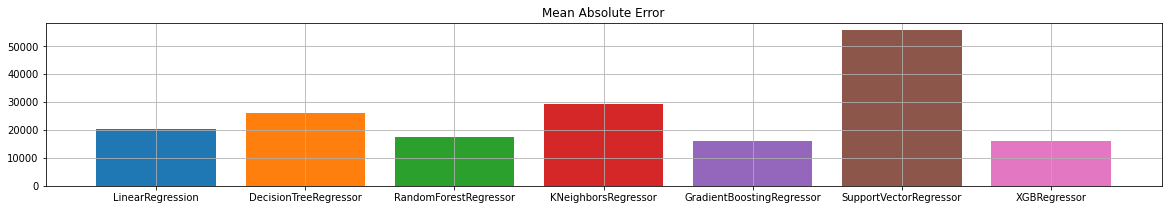

In [48]:
# MAE
plt.figure(figsize=(20, 3))
scores = dict()
for model_name in results.keys():
    plt.bar(model_name, results[model_name]['MAE'])
    scores[model_name] = results[model_name]['MAE']
display(sorted(scores.items(), key=lambda x: x[1]))
plt.title('Mean Absolute Error')
plt.grid()
plt.show()

[('XGBRegressor', 702405497.4659616),
 ('GradientBoostingRegressor', 706838477.758997),
 ('RandomForestRegressor', 873377933.0433462),
 ('LinearRegression', 1343191715.6307428),
 ('DecisionTreeRegressor', 1620293886.4780822),
 ('KNeighborsRegressor', 2166338089.3427944),
 ('SupportVectorRegressor', 6630089672.357525)]

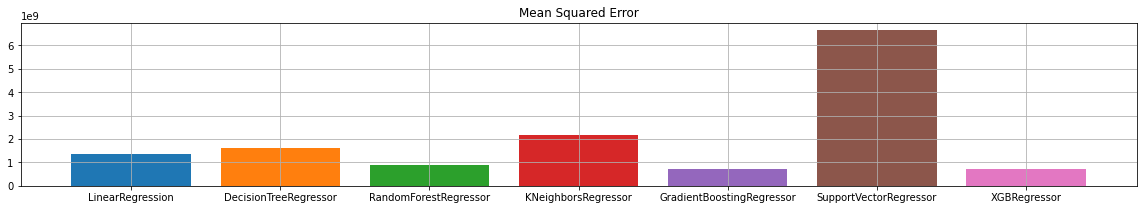

In [47]:
# MSE
plt.figure(figsize=(20, 3))
scores = dict()
for model_name in results.keys():
    plt.bar(model_name, results[model_name]['MSE'])
    scores[model_name] = results[model_name]['MSE']
display(sorted(scores.items(), key=lambda x: x[1]))
plt.title('Mean Squared Error')
plt.grid()
plt.show()

[('GradientBoostingRegressor', 26014.419718563113),
 ('XGBRegressor', 26140.03568906479),
 ('RandomForestRegressor', 28866.68017388424),
 ('LinearRegression', 34637.0925663753),
 ('DecisionTreeRegressor', 39594.82895167942),
 ('KNeighborsRegressor', 45764.57116157431),
 ('SupportVectorRegressor', 80882.75555554194)]

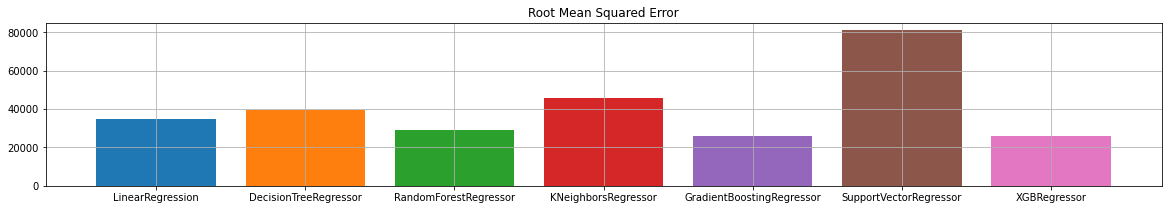

In [44]:
# RMSE
plt.figure(figsize=(20, 3))
scores = dict()
for model_name in results.keys():
    plt.bar(model_name, results[model_name]['RMSE'])
    scores[model_name] = results[model_name]['RMSE']
display(sorted(scores.items(), key=lambda x: x[1]))
plt.title('Root Mean Squared Error')
plt.grid()
plt.show()

[('LinearRegression', nan),
 ('GradientBoostingRegressor', 0.016914455596722302),
 ('XGBRegressor', 0.01692672934269062),
 ('RandomForestRegressor', 0.02086102617015787),
 ('DecisionTreeRegressor', 0.042319287977494735),
 ('KNeighborsRegressor', 0.04940115607435665),
 ('SupportVectorRegressor', 0.16009597270139136)]

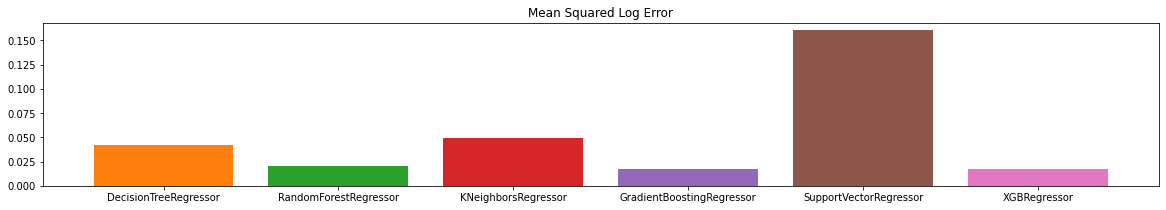

In [45]:
# MSLE
plt.figure(figsize=(20, 3))
scores = dict()
for model_name in results.keys():
    plt.bar(model_name, results[model_name]['MSLE'])
    scores[model_name] = results[model_name]['MSLE']
display(sorted(scores.items(), key=lambda x: x[1]))
plt.title('Mean Squared Log Error')
plt.show()

[('XGBRegressor', 0.8879742626936196),
 ('GradientBoostingRegressor', 0.8879032677696512),
 ('RandomForestRegressor', 0.8638394877781372),
 ('LinearRegression', 0.7978402321980244),
 ('DecisionTreeRegressor', 0.7395344472067813),
 ('KNeighborsRegressor', 0.6636267644718475),
 ('SupportVectorRegressor', -0.053788497555763114)]

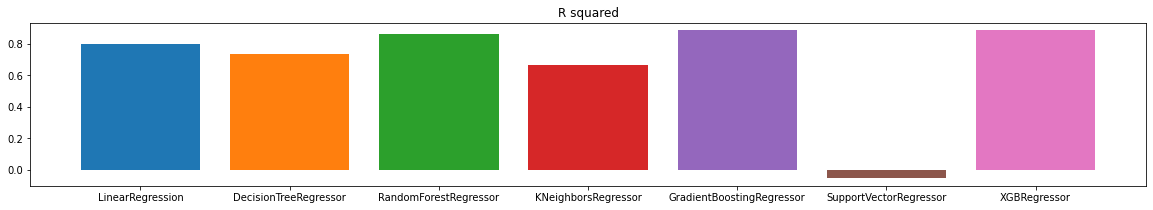

In [46]:
# R2
plt.figure(figsize=(20, 3))
scores = dict()
for model_name in results.keys():
    plt.bar(model_name, results[model_name]['R2'])
    scores[model_name] = results[model_name]['R2']
display(sorted(scores.items(), key=lambda x: x[1], reverse=True))
plt.title('R squared')
plt.show()

In [51]:
# Try for Data normalizaiton for Gradient Boosting Regressor
max_abs_scaler = MaxAbsScaler()
X_maxabs = max_abs_scaler.fit_transform(X)

standard_scaler = StandardScaler()
X_standard = standard_scaler.fit_transform(X)

min_max_scaler = MinMaxScaler()
X_minmax = min_max_scaler.fit_transform(X)

In [54]:
# Gradient Boosting Regressor
model = GradientBoostingRegressor(random_state = 42)
max_abs_result = evaluate_model(model, X_maxabs, y, n_splits=10)
print("After Max Abs Normalization")
display(max_abs_result)

model = GradientBoostingRegressor(random_state = 42)
standard_result = evaluate_model(model, X_standard, y, n_splits=10)
print("After Stadnard Normalization")
display(standard_result)

model = GradientBoostingRegressor(random_state = 42)
min_max_result = evaluate_model(model, X_minmax, y, n_splits=10)
print("After MinMax Normalization")
display(min_max_result)

After Max Abs Normalization


{'MAE': 15916.74985789899,
 'MSE': 707870710.9351395,
 'RMSE': 26031.850556290014,
 'MSLE': 0.016906152842476905,
 'R2': 0.8877304642598796}

After Stadnard Normalization


{'MAE': 15934.217627545535,
 'MSE': 708247987.6249934,
 'RMSE': 26040.146725391016,
 'MSLE': 0.016933890375543777,
 'R2': 0.887688764296247}

After MinMax Normalization


{'MAE': 15915.130534912272,
 'MSE': 707582643.586317,
 'RMSE': 26028.358599106006,
 'MSLE': 0.016911837279458247,
 'R2': 0.887775277246107}

#4. Model Training

In [ ]:
from sklearn.model_selection import GridSearchCV, RepeatedKFold

model = GradientBoostingRegressor(random_state = 42)
grid = dict()
grid['loss'] = ['huber']
grid['n_estimators'] = [100, 1000]
grid['learning_rate'] = [0.001, 0.01, 0.1]
grid['criterion'] = ['friedman_mse', 'squared_error']
grid['subsample'] = [0.7, 1.0]
grid['max_depth'] = [3, 5]
# define the evaluation procedure
cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=42)
# define the grid search procedure
grid_search = GridSearchCV(estimator=model, scoring='r2', param_grid=grid, n_jobs=-1, cv=10, verbose=3)
# execute the grid search
grid_result = grid_search.fit(X, y)
# summarize the best score and configuration
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_)) # summarize all scores that were evaluated
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Fitting 10 folds for each of 48 candidates, totalling 480 fits


In [ ]:
gbregression = GradientBoostingRegressor(random_state = 42)
gbregression.fit(X, y)